In [1]:
## Important:
## Parts of this code are Directly taken from PMEmo Repository with some Modification. The link for the same is 
## https://github.com/HuiZhangDB/PMEmo and the file is EDA_features_ex.ipynb
## After extracting features from it, exploration was done via other methods like Heatmap, Regressor graphs etc.
## given in this file and other files.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import neurokit as nk
from scipy import stats
from tqdm import tqdm_notebook
from sklearn.preprocessing import minmax_scale, scale
from scipy.stats import kurtosis, skew
from librosa.feature import mfcc

In [32]:
def window_with_overlap(a, window, stride):
    nrows = ((a.size-window)//stride)+1
#     print(a)
#     print(a.type())
#     s = pd.Series([1.1, 2.3])
#     a = np.array(s)
    n = np.array(pd.Series(a)).strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,window), strides=(stride*n,n))

def scr_features(times, phasic, SCR_Onsets, SCR_Peaks_Indexes, SCR_Peaks_Amplitudes):
    features = {}
    features['peakCount'] = len(SCR_Peaks_Indexes)
    features['meanpeakAmplitude'] = np.mean(SCR_Peaks_Amplitudes)
    RiseTime =  times[SCR_Peaks_Indexes] - times[SCR_Onsets]
    features['MeanRiseTime'] = np.mean(RiseTime)
    features['SumPeakAmplitude'] = np.sum(SCR_Peaks_Amplitudes)
    features['SumRiseTime'] = np.sum(RiseTime)
    features['SumAreas'] = np.trapz(phasic, x=times)
    return features

def time_domain_stats(times, signal):
    features = {}
    features['auc'] = np.trapz(signal, x=times)
    features['meanEDA'] = np.mean(signal)
    features['stdEDA'] = np.std(signal)
    features['kurtEDA'] = kurtosis(signal)
    features['skewEDA'] = skew(signal)
    features['meanDerivative'] = np.mean(np.gradient(signal))
    features['meanNegativeDerivative'] = np.mean((0-np.gradient(signal)))
    return features

def frequency_domain_stats(frequency_signal, frequency):
    features = {}
    features['SMA_f'] = np.trapz(np.abs(frequency_signal), x=frequency)
    features['meanEDA_f'] = np.mean(frequency_signal)
    features['stdEDA_f'] = np.std(frequency_signal)
    features['signalRange_f'] = frequency_signal.max() - frequency_signal.min()
    features['kurtEDA_f'] = kurtosis(frequency_signal)
    features['skewEDA_f'] = skew(frequency_signal)
#     FrequencyDomain_Statistical['harmonicsSummation']
    return features

def band_power(frequency_signal, frequency):
    features = {}
    signal_inbands = frequency_signal[(frequency>=0) & (frequency<=0.5)]
    features['signalEnergy'] = np.sum(np.abs(signal_inbands)**2)
    band1 = frequency_signal[(frequency>=0) & (frequency<0.1)]
    band2 = frequency_signal[(frequency>=0.1) & (frequency<0.2)]
    band3 = frequency_signal[(frequency>=0.2) & (frequency<0.3)]
    band4 = frequency_signal[(frequency>=0.3) & (frequency<0.4)]
    band5 = frequency_signal[(frequency>=0.4) & (frequency<=0.5)]
    bands = [band1, band2, band3, band4, band5]
    bands_sp = np.zeros(len(bands))
    for i, b in enumerate(bands):
        sp = np.sum(b**2)
        bands_sp[i] = sp
        features['SpectralPower_band'+str(i+1)] = sp
    features['minSpectralPower'] = np.min(bands_sp)
    features['maxSpectralPower'] = np.max(bands_sp)
    features['varSpectralPower'] = np.var(bands_sp)
    
    return features

        
def extract_eda_features(raw_eda, sampleRate=50, ifDynamic=False, window=50, stride=25):
    normalized_data = minmax_scale(raw_eda.reshape(-1, 1)).reshape(-1,)
    processed_results = nk.eda_process(normalized_data, sampling_rate=sampleRate)

    filtered_eda = processed_results['df']['EDA_Filtered']
    tonic = processed_results['df']['EDA_Tonic']
    phasic = processed_results['df']['EDA_Phasic']
    
    SCR_Onsets = processed_results['EDA']['SCR_Onsets']
    SCR_Peaks_Indexes  = processed_results['EDA']['SCR_Peaks_Indexes']
    SCR_Recovery_Indexes = processed_results['EDA']['SCR_Recovery_Indexes']
    SCR_Peaks_Amplitudes = processed_results['EDA']['SCR_Peaks_Amplitudes']
    
    signal = phasic
    times = np.arange(len(signal))/sampleRate

    features = pd.DataFrame()
    
    # static features 33 dimension
    if not ifDynamic:
        eda_features = {}
        # Time Domain: SCR Features, Statistical Features
        SCR_Features = scr_features(times, phasic, SCR_Onsets, 
                                    SCR_Peaks_Indexes, SCR_Peaks_Amplitudes)
        
        TimeStats = time_domain_stats(times, signal)
        # Frequency Domain: Statistical Features, Band Power
        frequency_signal = np.abs(np.fft.fft(signal))
        frequency = np.fft.fftfreq(signal.size, d=1/sampleRate)
        FrequencyStats = frequency_domain_stats(frequency_signal, frequency)
        BandPower = band_power(frequency_signal, frequency)
        
        eda_features.update(SCR_Features)
        eda_features.update(TimeStats)
        eda_features.update(FrequencyStats)
        eda_features.update(BandPower)
        
        # Time-Frequency Domain: MFCC Features
        n_mfcc = 20
        mfccCoefficients = mfcc(signal.values, sr=sampleRate, n_mfcc=n_mfcc)
        for i in range(n_mfcc):
            mfccCoef = mfccCoefficients[i,:]
            eda_features[f'meanMFCC[{i}]'] = np.mean(mfccCoef)
            eda_features[f'stdMFCC[{i}]'] = np.std(mfccCoef)
            eda_features[f'medianMFCC[{i}]'] = np.median(mfccCoef)
            eda_features[f'kurtMFCC[{i}]'] = kurtosis(mfccCoef.reshape(-1,))
            eda_features[f'skewMFCC[{i}]'] = skew(mfccCoef.reshape(-1,))
        features = pd.DataFrame(data=eda_features, index=[0])
        
    else: # dynamic features
        frames = window_with_overlap(signal, window, stride)
        time_frames = window_with_overlap(times, window, stride)
        
        for fidx, frame in enumerate(frames):
            eda_features = {}
            frame_time = fidx*0.5+1
            times = time_frames[fidx]
            eda_features['frameTime'] = frame_time
        
            # Time Domain: Statistical Features
            TimeStats = time_domain_stats(times, frame)
            
            # Frequency Domain: Statistical Features, Band Power
            frequency_signal = np.abs(np.fft.fft(frame))
            frequency = np.fft.fftfreq(frame.size, d=1/sampleRate)
            FrequencyStats = frequency_domain_stats(frequency_signal, frequency)
            BandPower = band_power(frequency_signal, frequency)

            eda_features.update(TimeStats)
            eda_features.update(FrequencyStats)
            eda_features.update(BandPower)   

            # Time-Frequency Domain: MFCC Features
            n_mfcc = 20
            mfccCoefficients = mfcc(frame, sr=sampleRate, n_mfcc=n_mfcc).reshape(-1,)
            for i in range(mfccCoefficients.size):
                eda_features[f'mfccCoefficient[{i}]'] = mfccCoefficients[i]
            eda_features['meanMFCC'] = np.mean(mfccCoefficients)
            eda_features['stdMFCC'] = np.std(mfccCoefficients)
            eda_features['medianMFCC'] = np.median(mfccCoefficients)
            eda_features['kurtMFCC'] = kurtosis(mfccCoefficients.reshape(-1,))
            eda_features['skewMFCC'] = skew(mfccCoefficients.reshape(-1,))
            features = features.append(pd.DataFrame(data=eda_features, index=[i]))
        
    return features

In [8]:
dir_path = '/Users/aditya_mac/Downloads/PMEmo2019/EDA'
eda_files = [f for f in os.listdir(dir_path) if f[-4:]=='.csv']
results = pd.DataFrame()
# window = 50
# stride = 25
for f in tqdm_notebook(eda_files):
# for f in ['1_EDA.csv', '4_EDA.csv']:
    musicId = f.split('_')[0]
    raw_eda = pd.read_csv(os.path.join(dir_path, f), index_col=0)
#     row_num, col_num = raw_eda.shape[0], raw_eda.shape[1]-1

    for c in raw_eda.columns:
        subjectId = c[-6:]
        features = extract_eda_features(raw_eda[c].values)
        features['subjectId'] = subjectId
        features['musicId'] = musicId
        results = results.append(features)

results.fillna(0)
results.to_csv('EDA_features_static.csv', index=False, columns=['subjectId', 'musicId']+list(results.columns[:-2]))

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1311
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1311
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1311
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1311
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1311
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1311
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1460
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1460
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1760
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1760
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1760
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1760
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1760
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1760
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1760
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=709
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=709
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=709
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=709
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=709
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=911
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2011
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2011
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2011
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2011
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1609
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1609
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1609
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1609
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1609
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1609
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1225
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1225
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1811
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1811
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1811
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1811
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=760
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=760
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=760
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=760
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=760
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1460
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1460
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1460
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1460
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1460
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1460
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1460
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1460
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1960
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1461
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1461
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=709
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=709
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=709
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=709
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/cor

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1410
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1410
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1410
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1410
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1410
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1410
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=611
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=611
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/c

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1560
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1160
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1160
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1811
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1811
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1811
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1811
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1460
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1460
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=810
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=810
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=810
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=810
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=810
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=810
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1310
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1625
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1625
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1625
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1625
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1625
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1625
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=911
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1060
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1261
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1110
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1110
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1110
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2011
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2011
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2011
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2011
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2011
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2011
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2010
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=860
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/cor

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1060
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1060
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1060
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1060
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1060
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1060
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1510
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1811
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1811
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1811
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1811
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1811
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1811
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=709
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1660
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1810
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1810
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1409
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1759
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1360
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1610
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1910
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1160
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1160
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1160
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1160
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1710
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1210
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa

In [11]:
eda_feature_set = pd.read_csv('EDA_features_static.csv')
eda_feature_set

,subjectId,musicId,peakCount,meanpeakAmplitude,MeanRiseTime,SumPeakAmplitude,SumRiseTime,SumAreas,auc,meanEDA,...,meanMFCC[18],stdMFCC[18],medianMFCC[18],kurtMFCC[18],skewMFCC[18],meanMFCC[19],stdMFCC[19],medianMFCC[19],kurtMFCC[19],skewMFCC[19]
0,110411,381,3,2.111733,2.113333,6.335199,6.34,46.767929,46.767929,2.722209,...,7.888079,0.457842,7.888079,-2.000000,2.964341e-15,7.601804,0.392642,7.601804,-2.000000,0.000000e+00
1,100166,381,4,1.591424,1.335000,6.365696,5.34,31.560833,31.560833,1.836237,...,5.603494,0.669070,5.603494,-2.000000,0.000000e+00,5.705672,0.187558,5.705672,-2.000000,7.098815e-15
2,100164,381,10,0.361110,0.932000,3.611102,9.32,31.832008,31.832008,1.851861,...,4.390841,0.318680,4.390841,-2.000000,0.000000e+00,4.981024,0.217892,4.981024,-2.000000,0.000000e+00
3,100162,381,2,0.876767,1.950000,1.753533,3.90,10.703462,10.703462,0.622333,...,7.972605,0.189908,7.972605,-2.000000,0.000000e+00,6.757667,0.025803,6.757667,-2.000000,-5.167265e-14
4,100165,381,3,0.373070,2.000000,1.119210,6.00,6.214685,6.214685,0.361489,...,3.647121,1.243773,3.647121,-2.000000,0.000000e+00,5.984193,0.984785,5.984193,-2.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7955,100153,919,12,0.020198,1.440000,0.242372,17.28,1.803541,1.803541,0.032092,...,4.541082,2.180757,4.920276,-1.056463,-2.295876e-01,5.179107,0.790138,5.166189,-0.821738,1.580741e-01
7956,100159,919,10,0.329626,1.474000,3.296258,14.74,18.703948,18.703948,0.332818,...,8.189329,1.612120,8.490627,-1.307452,-3.380697e-01,7.516647,0.994916,7.397799,-1.063074,-1.469808e-01
7957,100158,919,21,0.238632,0.775238,5.011282,16.28,78.835178,78.835178,1.402807,...,4.932190,1.421024,4.344459,0.264445,1.307457e+00,4.595156,0.979266,4.309450,-1.320767,2.283225e-01
7958,200439,919,22,0.433464,0.779091,9.536198,17.14,157.845471,157.845471,2.809063,...,4.110687,0.759852,4.226319,-1.155209,-3.264448e-01,3.564664,0.450564,3.637680,-1.099435,-4.339355e-01


In [17]:
eda_feature_set = pd.read_csv('EDA_features_static.csv')
static_labels = pd.read_csv('/Users/aditya_mac/Downloads/PMEmo2019/annotations/static_annotations.csv')
eda_dataset = pd.merge(eda_feature_set, static_labels, on=['musicId']).dropna()
eda_dataset.to_csv('eda_dataset.csv', index=False)

In [18]:
df = pd.read_csv('eda_dataset.csv')
df

,subjectId,musicId,peakCount,meanpeakAmplitude,MeanRiseTime,SumPeakAmplitude,SumRiseTime,SumAreas,auc,meanEDA,...,medianMFCC[18],kurtMFCC[18],skewMFCC[18],meanMFCC[19],stdMFCC[19],medianMFCC[19],kurtMFCC[19],skewMFCC[19],Arousal(mean),Valence(mean)
0,110411,381,3,2.111733,2.113333,6.335199,6.34,46.767929,46.767929,2.722209,...,7.888079,-2.000000,2.964341e-15,7.601804,0.392642,7.601804,-2.000000,0.000000e+00,0.9375,0.8000
1,100166,381,4,1.591424,1.335000,6.365696,5.34,31.560833,31.560833,1.836237,...,5.603494,-2.000000,0.000000e+00,5.705672,0.187558,5.705672,-2.000000,7.098815e-15,0.9375,0.8000
2,100164,381,10,0.361110,0.932000,3.611102,9.32,31.832008,31.832008,1.851861,...,4.390841,-2.000000,0.000000e+00,4.981024,0.217892,4.981024,-2.000000,0.000000e+00,0.9375,0.8000
3,100162,381,2,0.876767,1.950000,1.753533,3.90,10.703462,10.703462,0.622333,...,7.972605,-2.000000,0.000000e+00,6.757667,0.025803,6.757667,-2.000000,-5.167265e-14,0.9375,0.8000
4,100165,381,3,0.373070,2.000000,1.119210,6.00,6.214685,6.214685,0.361489,...,3.647121,-2.000000,0.000000e+00,5.984193,0.984785,5.984193,-2.000000,0.000000e+00,0.9375,0.8000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7684,100153,919,12,0.020198,1.440000,0.242372,17.28,1.803541,1.803541,0.032092,...,4.920276,-1.056463,-2.295876e-01,5.179107,0.790138,5.166189,-0.821738,1.580741e-01,0.6000,0.7375
7685,100159,919,10,0.329626,1.474000,3.296258,14.74,18.703948,18.703948,0.332818,...,8.490627,-1.307452,-3.380697e-01,7.516647,0.994916,7.397799,-1.063074,-1.469808e-01,0.6000,0.7375
7686,100158,919,21,0.238632,0.775238,5.011282,16.28,78.835178,78.835178,1.402807,...,4.344459,0.264445,1.307457e+00,4.595156,0.979266,4.309450,-1.320767,2.283225e-01,0.6000,0.7375
7687,200439,919,22,0.433464,0.779091,9.536198,17.14,157.845471,157.845471,2.809063,...,4.226319,-1.155209,-3.264448e-01,3.564664,0.450564,3.637680,-1.099435,-4.339355e-01,0.6000,0.7375


In [33]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

dir_path = '/Users/aditya_mac/Downloads/PMEmo2019/EDA'
eda_files = [f for f in os.listdir(dir_path) if f[-4:]=='.csv']
results = pd.DataFrame()

# window = 50
# stride = 25

for f in tqdm_notebook(eda_files):
# for f in ['1_EDA.csv', '4_EDA.csv']:
    musicId = f.split('_')[0]
    raw_eda = pd.read_csv(os.path.join(dir_path, f), index_col=0)

    for c in raw_eda.columns:
        subjectId = c
        features = extract_eda_features(raw_eda[c].values, ifDynamic=True)
        features['subjectId'] = subjectId
        features['musicId'] = musicId
        results = results.append(features)

results.fillna(0)
results.to_csv('EDA_features_dynamic.csv', index=False, columns=['subjectId', 'musicId']+list(results.columns[:-2]))

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=50
  n_fft, y.shape[-1]
/anaconda3/lib/python3.7/site-packages/librosa/core/spectr

In [25]:
import pandas
print(pandas.__version__)

1.0.0


In [35]:
dfx = pd.read_csv('EDA_features_dynamic.csv')

In [36]:
dfx

,subjectId,musicId,frameTime,auc,meanEDA,stdEDA,kurtEDA,skewEDA,meanDerivative,meanNegativeDerivative,...,mfccCoefficient[15],mfccCoefficient[16],mfccCoefficient[17],mfccCoefficient[18],mfccCoefficient[19],meanMFCC,stdMFCC,medianMFCC,kurtMFCC,skewMFCC
0,110411,381,1.0,0.212583,0.216388,0.111359,-0.889226,-0.434498,0.007661,-0.007661,...,4.154451,5.606590,4.599812,3.646856,-1.512503,10.745462,53.325607,6.912830,6.514761,-1.789438
1,110411,381,1.5,0.366725,0.374054,0.076040,-1.177759,-0.140998,0.005158,-0.005158,...,7.152814,10.779310,11.297976,6.021943,5.894739,9.924691,58.633622,9.388220,9.344167,-2.709722
2,110411,381,2.0,0.499027,0.510331,0.090126,-0.115833,0.734215,0.007510,-0.007510,...,4.853678,2.654684,1.897298,2.994429,6.126635,12.403063,32.703282,6.329864,4.357783,0.520581
3,110411,381,2.5,0.953894,0.980365,0.504779,-0.485869,0.922980,0.033796,-0.033796,...,-0.864375,2.512425,5.043724,2.707049,5.351343,19.754522,28.159201,9.938232,6.284702,2.545846
4,110411,381,3.0,2.047472,2.087102,0.798597,-1.385084,-0.197783,0.048822,-0.048822,...,11.990471,5.555218,8.116848,5.851847,1.536362,20.764219,31.312209,14.845086,2.793208,0.656018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595623,110410,919,54.0,0.297633,0.304757,0.052004,0.702678,1.479562,0.003541,-0.003541,...,16.430591,6.410216,-6.585837,-4.106386,4.701165,8.699609,57.360028,16.468108,6.373872,-2.000026
595624,110410,919,54.5,0.412910,0.421022,0.094706,-1.465869,-0.340100,0.005150,-0.005150,...,5.113597,7.844226,18.852819,23.952933,15.722502,11.206651,66.812236,15.698342,9.921255,-2.762169
595625,110410,919,55.0,0.566722,0.578632,0.089405,-1.186208,0.498784,0.005922,-0.005922,...,10.879435,7.866637,6.631480,3.481934,4.811862,12.113825,54.634470,10.200718,7.743103,-2.235003
595626,110410,919,55.5,0.701971,0.715436,0.079978,-0.410814,-0.841000,0.005586,-0.005586,...,-5.777049,2.949777,11.134892,6.336200,0.721818,11.124662,62.479667,10.797697,6.747619,-1.755010


In [37]:
dfx.shape

(595628, 50)

In [40]:
annotations = pd.read_csv("/Users/aditya_mac/Downloads/PMEmo2019/annotations/dynamic_annotations.csv")

eda_features = pd.read_csv('EDA_features_dynamic.csv').astype(float)
eda_dataset = pd.merge(eda_features, annotations, on=['musicId', 'frameTime']).dropna()
dd = eda_dataset.groupby(by=['musicId', 'frameTime'], as_index=False).mean()

In [138]:
dd
testsongs = [1,381]
iftestset = dd['musicId'].apply(lambda x: x in testsongs)
# print(len(iftestset == True))
testset = dd[iftestset]
trainset = dd[~iftestset]
testset

,musicId,frameTime,subjectId,auc,meanEDA,stdEDA,kurtEDA,skewEDA,meanDerivative,meanNegativeDerivative,...,mfccCoefficient[17],mfccCoefficient[18],mfccCoefficient[19],meanMFCC,stdMFCC,medianMFCC,kurtMFCC,skewMFCC,Arousal(mean),Valence(mean)
0,1.0,15.5,111277.8,1.115977,1.138890,0.048442,-1.208544,0.172049,-0.002742,0.002742,...,6.347103,5.654210,7.353584,6.952108,64.372597,10.999682,9.527445,-2.451492,0.437662,0.559975
1,1.0,16.0,111277.8,1.050445,1.071912,0.039205,-0.992753,0.013443,-0.002504,0.002504,...,7.752146,6.481111,6.631390,6.826462,67.077755,12.462917,10.164304,-2.807505,0.437775,0.560650
2,1.0,16.5,111277.8,0.998610,1.019276,0.041443,-0.810991,0.174334,-0.001738,0.001738,...,8.022753,7.000912,7.192596,6.188604,65.489784,10.557276,9.240587,-2.436417,0.443125,0.559900
3,1.0,17.0,111277.8,0.978219,0.998284,0.073067,-1.176674,0.081099,-0.000303,0.000303,...,9.002904,8.713021,6.391006,8.259135,68.257263,14.723816,10.437735,-2.941798,0.442887,0.560212
4,1.0,17.5,111277.8,0.962822,0.982097,0.056340,-0.632945,-0.360683,-0.001064,0.001064,...,3.711254,3.031527,4.823265,7.511321,65.361105,11.787457,8.936709,-2.270221,0.444563,0.563337
5,1.0,18.0,111277.8,0.940320,0.959962,0.055825,-0.915625,0.245574,-0.000518,0.000518,...,9.748791,7.927656,5.045265,8.134178,65.317600,12.520659,9.621659,-2.511068,0.451663,0.569113
6,1.0,18.5,111277.8,0.938411,0.957209,0.066210,-0.987445,-0.295227,0.000073,-0.000073,...,8.353870,7.366422,7.588525,7.671929,64.882622,13.268094,9.483572,-2.666836,0.452000,0.572662
7,1.0,19.0,111277.8,0.921156,0.939903,0.044136,-0.576340,0.100394,-0.001308,0.001308,...,5.466792,6.245422,6.383489,7.215410,61.098262,10.937402,9.234662,-2.459964,0.450775,0.574775
8,1.0,19.5,111277.8,0.886420,0.904546,0.063988,-1.152960,-0.060906,-0.001385,0.001385,...,6.656540,5.079860,6.439940,8.687733,60.330304,12.352233,8.948538,-2.425031,0.449538,0.582887
9,1.0,20.0,111277.8,0.852337,0.869610,0.062793,-1.124857,-0.087208,-0.001645,0.001645,...,4.905570,5.235436,6.521212,7.616968,61.905479,12.575813,10.367779,-2.964453,0.428675,0.589225


In [121]:
eda_dataset.to_csv("eda_dataset_dy.csv",index=False)

In [137]:
dd[dd["musicId"] == 381]
# dd.shape

,musicId,frameTime,subjectId,auc,meanEDA,stdEDA,kurtEDA,skewEDA,meanDerivative,meanNegativeDerivative,...,mfccCoefficient[17],mfccCoefficient[18],mfccCoefficient[19],meanMFCC,stdMFCC,medianMFCC,kurtMFCC,skewMFCC,Arousal(mean),Valence(mean)
12356,381.0,15.5,111209.8,1.679630,1.713434,0.105590,-0.891329,0.101498,-0.006805,0.006805,...,7.592547,4.627865,3.554506,9.391691,59.504897,11.964741,8.031881,-1.869660,0.937112,0.808887
12357,381.0,16.0,111209.8,1.502405,1.533799,0.105725,-1.044311,0.310200,-0.006023,0.006023,...,6.674943,4.768991,5.408661,9.195949,61.645792,13.535308,8.615809,-1.960088,0.941550,0.818425
12358,381.0,16.5,111209.8,1.447633,1.478687,0.125968,-0.632827,0.010989,0.001518,-0.001518,...,6.347202,4.318501,4.048799,9.197161,59.779511,11.712955,8.816275,-1.480506,0.948987,0.831100
12359,381.0,17.0,111209.8,1.555833,1.587409,0.141139,-0.856306,0.037853,0.006217,-0.006217,...,5.505726,4.032768,6.134019,7.757380,63.287699,10.872947,9.214045,-1.811276,0.943438,0.826650


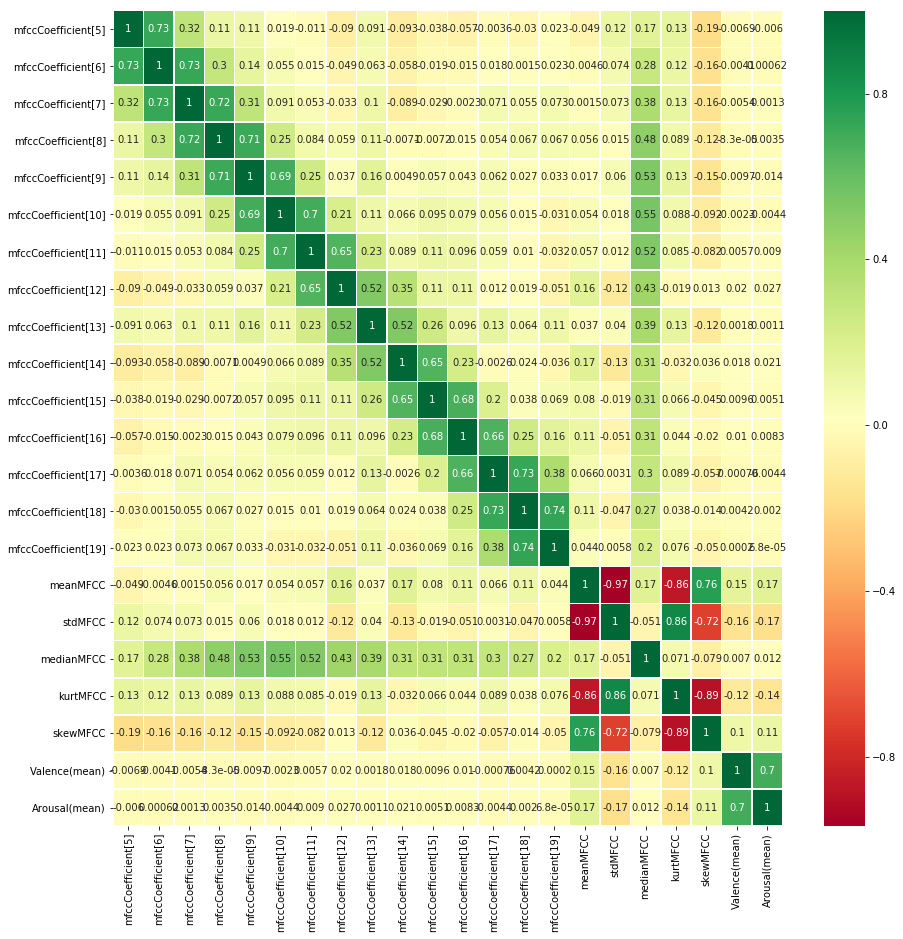

In [97]:
import seaborn as sns
data = dd.iloc[:,list(range(30,50)) + [-1,-2]]
# data = pd.concat([dd.iloc[:,0:10], dd.iloc[:,-2:]], ignore_index=True,axis = 1)
corrmat = data.corr()
top_corr_features = corrmat.index
# g = sns.heatmap(data[top_corr_features].corr(),annot = True,cmap = 'RdYlGn')

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(data[top_corr_features].corr(), annot=True, linewidths=.5, ax=ax,cmap = 'RdYlGn')

In [89]:
list(range(0,10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [99]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']